In [1]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean, circvar
from matplotlib.animation import FuncAnimation

import seaborn as sns

from matplotlib import rc
import yaml
import os

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5') # conda create -n newenv -c conda-forge ffmpeg

with open("cal-settings.yml", 'r') as file:
    vars = yaml.safe_load(file)
    RX_TX_SAME_CHANNEL = vars["RX_TX_SAME_CHANNEL"]

print("Cable connections")
if RX_TX_SAME_CHANNEL:
    REF_RX_CH = FREE_TX_CH = 0
    LOOPBACK_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH0 RX\nCH1 TX-->CH1 RX\nCH0 TX -->")
else:
    LOOPBACK_RX_CH = FREE_TX_CH = 0
    REF_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH1 RX\nCH1 TX-->CH0 RX\nCH0 TX -->")

ref_rx = f"rx_ch{REF_RX_CH}"

Cable connections

PLL REF-->CH1 RX
CH1 TX-->CH0 RX
CH0 TX -->


In [2]:
timestamp = "20240610133936"  # 20240610133936 -> wrong phase_diff1 and 2 (wrong channels selected --')

usrp_files = [f'data_T01_{timestamp}.txt', f'data_T04_{timestamp}.txt']


scope_file = f'data_scope_{timestamp}.txt'

In [3]:
scope_df = pd.read_csv(scope_file, names=[
                 "meas_id", "phase_diff", "phase_diff_13", "phase_diff_23"], header=None, sep=r'\s+')


fields = ["meas_id", "hostname", "meas_type", "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "rx_var_ch0", "rx_var_ch1", "rx_ampl_var_ch0", "rx_ampl_var_ch1"]


dfs = [pd.read_csv(file, names=fields, header=None, sep=';') for file in usrp_files]


merged_df = pd.merge(dfs[0], dfs[1], on=['meas_id', "meas_type"], how='outer',
                     suffixes=('_df1', '_df2'))

merged_df["phase_diff"] = None

scope_df.loc[:,"phase_diff"] = (scope_df["phase_diff"] + 180) % 360 - 180

# Iterate over rows
# remove rows of scope with no data_scope
i = 1
for index, row in scope_df.iterrows():
    if  row["meas_id"] != i:
        print(f"Lost measurement {i}, going to remove it from the RPI files")
        merged_df = merged_df[merged_df.meas_id != i]
        i+= 1 # advance with one extra due to lost value
    merged_df.loc[merged_df['meas_id'] ==
                row['meas_id'], "phase_diff"] = row["phase_diff"]
    if not np.any(merged_df["meas_id"] == row["meas_id"]):
        print(f"No match found for {row["meas_id"]}")
    i+=1

# given that we meanly want to plot things, shift the radians to degrees and wrap around

fltr_pllck = merged_df['meas_type'] == "PLLCK"
fltr_lbck = merged_df['meas_type'] == "LBCK"
fltr_pll = merged_df['meas_type'] == "PLL"
fltr_lb = merged_df['meas_type'] == "LB"


fltr_pll_var1 = merged_df[f"rx_var_ch{REF_RX_CH}_df1"] < 0.0001
fltr_pll_var2 = merged_df[f"rx_var_ch{REF_RX_CH}_df2"] < 0.0001

fltr_lb_var1 = merged_df[f"rx_var_ch{LOOPBACK_RX_CH}_df1"] < 0.0001
fltr_lb_var2 = merged_df[f"rx_var_ch{LOOPBACK_RX_CH}_df2"] < 0.0001


# put nans were the values do not mean anything
# during PLL measurement, all other rxs should be nan
merged_df.loc[fltr_pll, f"rx_var_ch{LOOPBACK_RX_CH}_df1"] = np.nan
merged_df.loc[fltr_pll, f"rx_var_ch{LOOPBACK_RX_CH}_df2"] = np.nan

merged_df.loc[fltr_pll, f"rx_ch{LOOPBACK_RX_CH}_df1"] = np.nan
merged_df.loc[fltr_pll, f"rx_ch{LOOPBACK_RX_CH}_df2"] = np.nan



pll_rx_chs = [f"rx_ch{REF_RX_CH}_df1", f"rx_ch{REF_RX_CH}_df2"] 
lb_rx_chs = [f"rx_ch{LOOPBACK_RX_CH}_df1", f"rx_ch{LOOPBACK_RX_CH}_df2"] 

Lost measurement 69, going to remove it from the RPI files
Lost measurement 918, going to remove it from the RPI files
Lost measurement 943, going to remove it from the RPI files
Lost measurement 1334, going to remove it from the RPI files
Lost measurement 1336, going to remove it from the RPI files
Lost measurement 1689, going to remove it from the RPI files
Lost measurement 1735, going to remove it from the RPI files
No match found for 2150.0
No match found for 2151.0
No match found for 2152.0
No match found for 2153.0
No match found for 2154.0
No match found for 2155.0
No match found for 2156.0
No match found for 2157.0
No match found for 2158.0
No match found for 2159.0
No match found for 2160.0
No match found for 2161.0
No match found for 2162.0
No match found for 2163.0
No match found for 2164.0
No match found for 2165.0
No match found for 2166.0
No match found for 2167.0
No match found for 2168.0
No match found for 2169.0
No match found for 2170.0
No match found for 2171.0
No ma

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

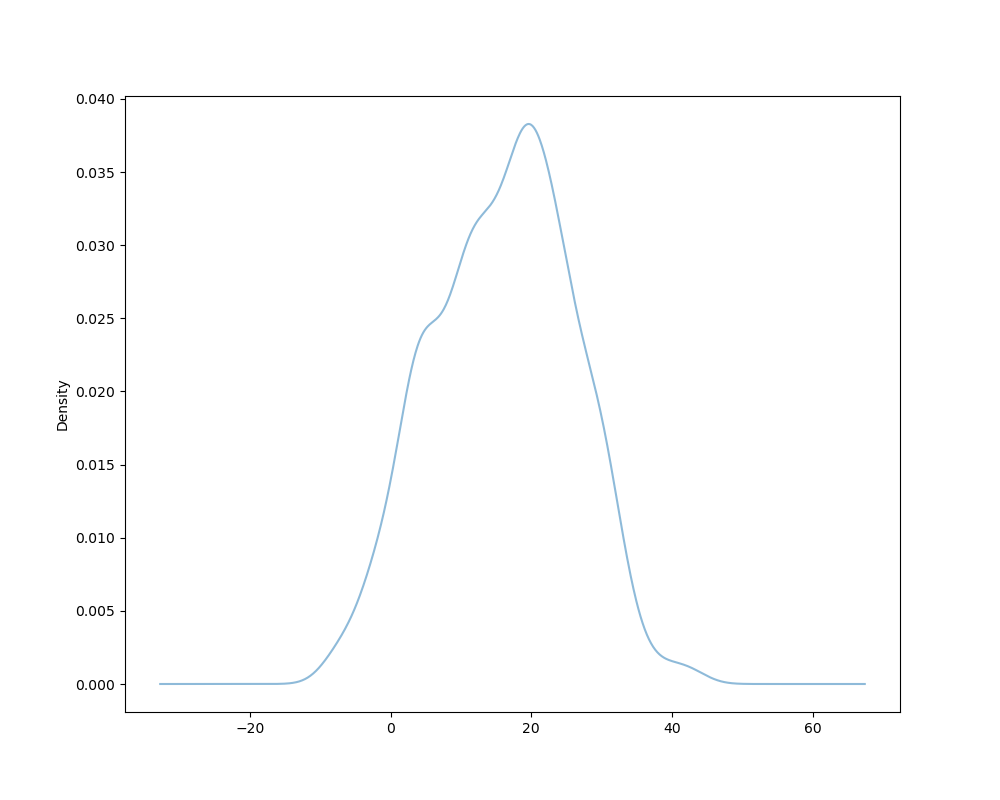

Mean: 2.64°
circ mean: 3.08°
circ var: 0.97°


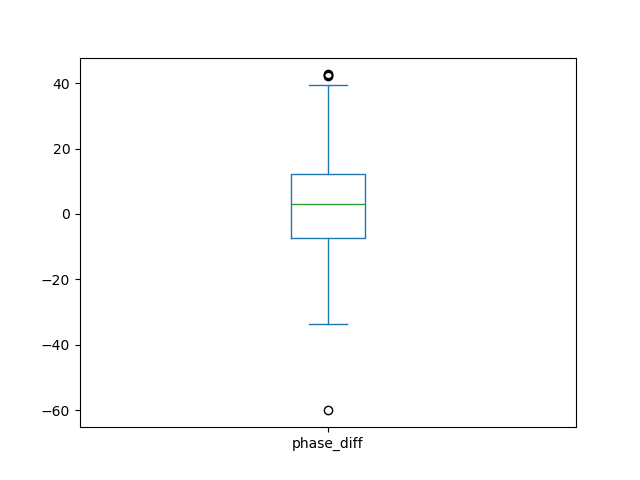

In [4]:
# plot phase_diff only where PLL variance is below 0.001
plt.figure();
fltr_clean_pll = merged_df[f"rx_var_ch{REF_RX_CH}_df1"] < 0.0001
# merged_df.loc[:, "phase_diff"].plot.hist(
#     figsize=(10, 8), bins=52, alpha=0.5);
merged_df.loc[fltr_clean_pll, "phase_diff"].plot.kde(figsize=(10, 8), alpha=0.5)
plt.show()

plt.figure()
scope_df["phase_diff"].plot.box()

print(f"Mean: {np.mean(scope_df['phase_diff']):.2f}°")
print(f"circ mean: {circmean(scope_df['phase_diff']):.2f}°")
print(f"circ var: {circvar(scope_df['phase_diff']):.2f}°")
plt.show()

In [5]:
def distance_from_0_or_360(angles):
    """
    Compute the distance of each angle from 0 or 360 degrees.
    
    Parameters:
    angles (array-like): List or array of angles in degrees.
    
    Returns:
    np.ndarray: Array of minimum distances from 0 or 360 degrees.
    """
    angles = np.mod(
        angles, 2*np.pi)  # Ensure all angles are within 0 to 360 degrees
    distance_from_0 = np.abs(angles - 0)
    distance_from_360 = np.abs(angles - 2*np.pi)

    return np.rad2deg(np.minimum(distance_from_0, distance_from_360))

2142
2142


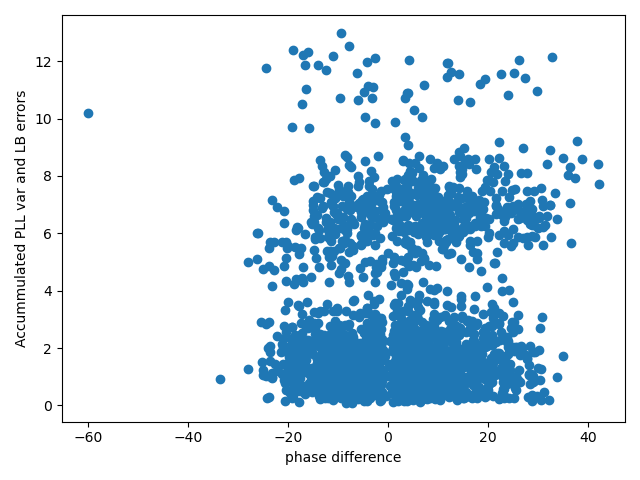

In [6]:
x = merged_df.loc[fltr_pll, "phase_diff"].dropna().values
y = merged_df.where(fltr_pll).loc[:, f"rx_var_ch{REF_RX_CH}_df1"].dropna().values + merged_df.where(fltr_pll).loc[:, f"rx_var_ch{REF_RX_CH}_df2"].dropna().values + distance_from_0_or_360(merged_df.where(fltr_lbck).loc[:, f"rx_ch{LOOPBACK_RX_CH}_df1"].dropna().values) + distance_from_0_or_360(merged_df.where(fltr_lbck).loc[:, f"rx_ch{LOOPBACK_RX_CH}_df2"].dropna().values)

print(len(x))
print(len(y))


plt.figure();
plt.scatter(x,y);
plt.ylabel("Accummulated PLL var and LB errors")
plt.xlabel("phase difference");
plt.tight_layout();
plt.show();

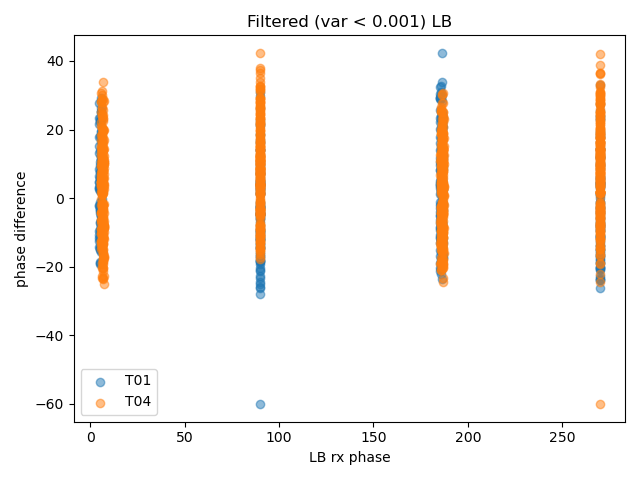

In [7]:
x1 = merged_df.loc[fltr_lb & fltr_lb_var1, f"rx_ch{LOOPBACK_RX_CH}_df1"].dropna().values
x2 = merged_df.loc[fltr_lb & fltr_lb_var2, f"rx_ch{LOOPBACK_RX_CH}_df2"].dropna().values

y1 = merged_df.loc[fltr_lb & fltr_lb_var1, "phase_diff"].dropna().values
y2 = merged_df.loc[fltr_lb & fltr_lb_var2, "phase_diff"].dropna().values


plt.figure()
plt.scatter(np.rad2deg(x1), y1, label="T01", alpha=0.5)
plt.scatter(np.rad2deg(x2), y2, label="T04", alpha=0.5)
plt.ylabel("phase difference")
plt.xlabel("LB rx phase")
plt.title("Filtered (var < 0.001) LB")
plt.tight_layout()
plt.legend()
plt.show()

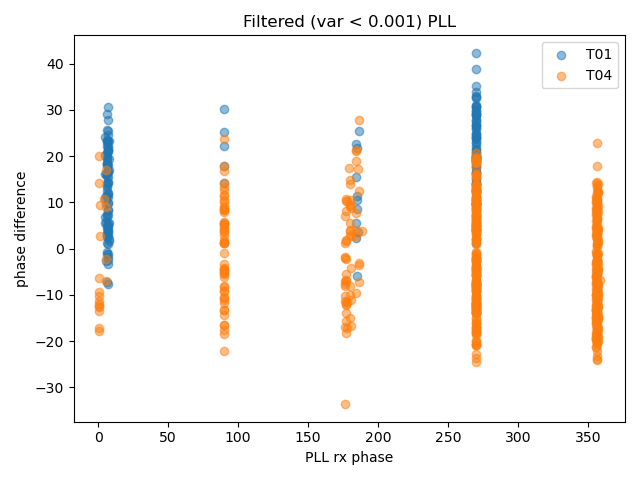

In [8]:
x1 = merged_df.loc[fltr_pll & fltr_pll_var1, f"rx_ch{REF_RX_CH}_df1"].dropna().values
x2 = merged_df.loc[fltr_pll & fltr_pll_var2, f"rx_ch{REF_RX_CH}_df2"].dropna().values

y1 = merged_df.loc[fltr_pll & fltr_pll_var1, "phase_diff"].dropna().values
y2 = merged_df.loc[fltr_pll & fltr_pll_var2, "phase_diff"].dropna().values

plt.figure()
plt.scatter(np.rad2deg(x1), y1, label="T01", alpha=0.5)
plt.scatter(np.rad2deg(x2), y2, label="T04", alpha=0.5)
plt.ylabel("phase difference")
plt.xlabel("PLL rx phase")
plt.title("Filtered (var < 0.001) PLL")
plt.tight_layout()
plt.legend()
plt.show()

In [9]:
# find good lb values for each USRP
lb_measid_1 = set(merged_df.loc[fltr_lb & fltr_lb_var1, f"meas_id"].dropna().values)
lb_measid_2 = set(merged_df.loc[fltr_lb & fltr_lb_var2, f"meas_id"].dropna().values)


pll_measid_1 = set(merged_df.loc[fltr_pll & fltr_pll_var1, f"meas_id"].dropna().values)
pll_measid_2 = set(merged_df.loc[fltr_pll & fltr_pll_var2, f"meas_id"].dropna().values)

# Find the intersection of all sets
common_values = lb_measid_1 & lb_measid_2 & pll_measid_1 & pll_measid_2

# Convert the result back to a numpy array (optional)
common_values_array = np.array(list(common_values))

print("Common values:", common_values_array)

print([merged_df.loc[fltr_lb & (merged_df["meas_id"]==c), f"phase_diff"].values for c in common_values_array])

Common values: [ 259 1510 1416  654  783  336]
[array([12.737325927263754], dtype=object), array([8.832511837765026], dtype=object), array([21.325854205376714], dtype=object), array([18.827125162071383], dtype=object), array([2.6183481393755983], dtype=object), array([12.433849242761198], dtype=object)]


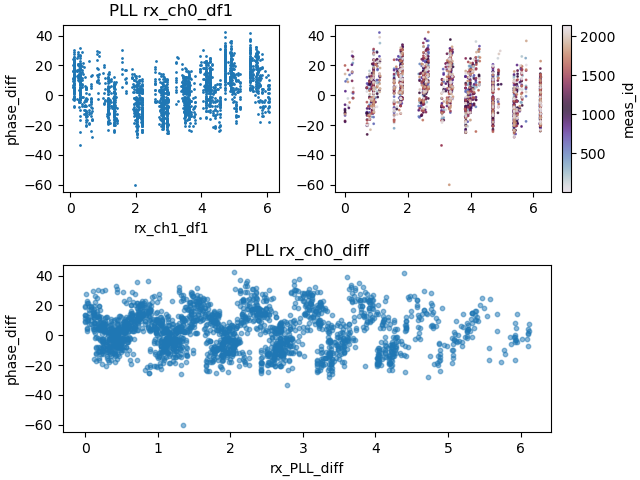

0.5259103641456583
0       4.246035
1       4.243265
2       4.237541
3       4.235236
4       2.890293
          ...   
8591    3.530586
8592    2.369935
8593    2.380926
8594    2.368643
8595    2.371536
Name: rx_PLL_diff, Length: 8568, dtype: float64


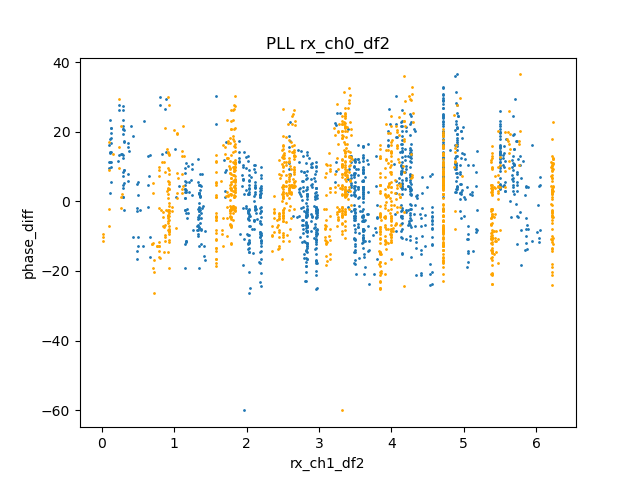

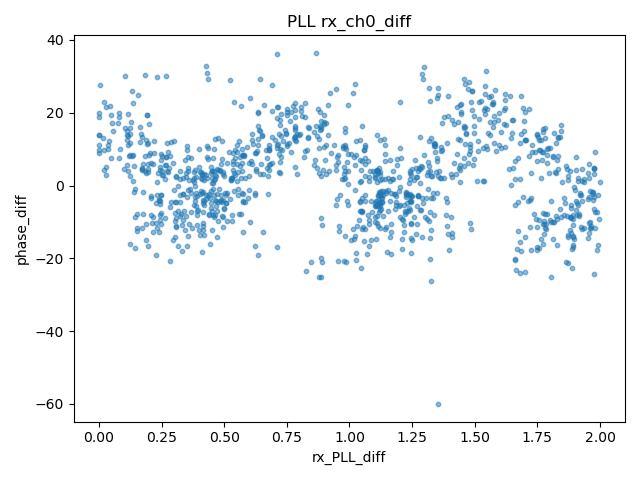

In [10]:
merged_df["rx_PLL_diff"] = np.abs(merged_df[pll_rx_chs[0]] - merged_df[pll_rx_chs[1]])

fig, axd = plt.subplot_mosaic(
    [["left", "right"], ["bottom", "bottom"]], constrained_layout=True
)

merged_df.where(merged_df["meas_type"] == "PLL").plot.scatter(
    x=pll_rx_chs[0], y="phase_diff", title="PLL rx_ch0_df1", ax=axd["left"], s=1
)

pll_df = merged_df[merged_df["meas_type"] == "PLL"]

sc = axd["right"].scatter(
    pll_df[pll_rx_chs[1]],
    pll_df["phase_diff"],
    c=pll_df["meas_id"],
    cmap="twilight",
    alpha=0.8,
    s=1,
)

plt.colorbar(sc, label="meas_id")

merged_df.where(fltr_pll).plot.scatter(
    x="rx_PLL_diff",
    y="phase_diff",
    title="PLL rx_ch0_diff",
    ax=axd["bottom"],
    alpha=0.5,
    s=10,
)

plt.show()

# Define a function to check if a number is within 5 of a multiple of 45


def is_within_5_of_multiple_of_45(x):
    return (x % 45 <= 2) or (x % 45 >= 43)


# Select rows where 'rx_PLL_diff' is a multiple of 45
fltr_45 = merged_df["rx_PLL_diff"].apply(is_within_5_of_multiple_of_45)
print(sum(fltr_45) / len(fltr_45))
print(merged_df["rx_PLL_diff"])
filtered_df = merged_df[fltr_45]
ax = filtered_df.where(fltr_pll).plot.scatter(
    x=pll_rx_chs[0], y="phase_diff", title="PLL rx_ch0_df1", s=1
)
filtered_df.where(fltr_pll).plot.scatter(
    x=pll_rx_chs[1], y="phase_diff", title="PLL rx_ch0_df2", s=1, ax=ax, c="orange"
)
plt.show()

filtered_df.where(fltr_pll).plot.scatter(
    x="rx_PLL_diff", y="phase_diff", title="PLL rx_ch0_diff", alpha=0.5, s=10
)
plt.tight_layout()
plt.show()

In [11]:
resolution_deg = 10
resolution_rad = np.deg2rad(resolution_deg)


# get the locations were the RX PLL was within 1 degree of 270 degrees


good_meas_ids = (
    merged_df.where(
        merged_df.loc[fltr_pll, pll_rx_chs[0]] % (np.pi / 4) < resolution_rad
    )["meas_id"]
    .dropna()
    .values
)

filtered_df = merged_df.loc[merged_df["meas_id"].isin(good_meas_ids)]

# display(filtered_df.dropna())

good_meas_ids = (
    filtered_df.where(
        filtered_df.loc[fltr_pll, pll_rx_chs[1]] % (np.pi / 4) < resolution_rad
    )["meas_id"]
    .dropna()
    .values
)


filtered_df = filtered_df.loc[filtered_df["meas_id"].isin(good_meas_ids)]

# display(filtered_df.dropna())


# get the locations were the rx LB was within 1 degree of 90 degrees

good_meas_ids = (
    filtered_df.where(
        filtered_df.loc[fltr_lb, lb_rx_chs[0]] %  (np.pi / 4) < resolution_rad
    )["meas_id"]
    .dropna()
    .values
)


filtered_df = filtered_df.loc[filtered_df["meas_id"].isin(good_meas_ids)]

# display(filtered_df.dropna())

good_meas_ids = (
    filtered_df.where(
        filtered_df.loc[fltr_lb, lb_rx_chs[1]] %  (np.pi / 4) < resolution_rad
    )["meas_id"]
    .dropna()
    .values
)


filtered_df = filtered_df.loc[filtered_df["meas_id"].isin(good_meas_ids)]

display(filtered_df.dropna())

,meas_id,hostname_df1,meas_type,tx_ch0_df1,tx_ch1_df1,rx_ch0_df1,rx_ch1_df1,rx_var_ch0_df1,rx_var_ch1_df1,rx_ampl_var_ch0_df1,...,tx_ch0_df2,tx_ch1_df2,rx_ch0_df2,rx_ch1_df2,rx_var_ch0_df2,rx_var_ch1_df2,rx_ampl_var_ch0_df2,rx_ampl_var_ch1_df2,phase_diff,rx_PLL_diff
28,8,T01,LB,0.0,0.000000,2.466022,0.099367,0.002806,0.000068,0.002527,...,0.0,0.000000,5.641589,3.163420,0.002107,0.000009,0.002543,0.004343,5.526124,3.064053
29,8,T01,LBCK,0.0,-2.466022,6.263644,0.076008,0.000004,0.000041,0.002637,...,0.0,-5.641589,6.279272,3.164711,0.000011,0.000008,0.002868,0.004146,5.526124,3.088704
31,8,T01,PLLCK,0.0,-2.382940,0.060282,0.077301,0.000017,0.000042,0.002600,...,0.0,-2.495410,3.120043,3.144270,0.000009,0.000002,0.002539,0.004462,5.526124,3.066969
264,67,T01,LB,0.0,0.000000,0.863458,5.583977,0.002363,0.002046,0.001131,...,0.0,0.000000,3.239179,3.982534,0.000045,0.002575,0.002809,0.001364,11.660249,1.601442
265,67,T01,LBCK,0.0,-0.863458,0.018379,5.570972,0.000007,0.002075,0.004111,...,0.0,-3.239179,0.014869,4.006694,0.000005,0.002616,0.002966,0.001268,11.660249,1.564278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,2014,T01,LBCK,0.0,-0.877634,0.009244,0.118416,0.000007,0.000078,0.004439,...,0.0,-2.490120,6.272113,2.413885,0.000005,0.001978,0.002725,0.000775,3.865495,2.295469
8055,2014,T01,PLLCK,0.0,-0.751158,0.138880,0.119600,0.000144,0.000081,0.004181,...,0.0,-0.102269,2.364130,2.376129,0.001221,0.001945,0.000806,0.000666,3.865495,2.256529
8300,2076,T01,LB,0.0,0.000000,4.030955,0.136194,0.002103,0.000097,0.000953,...,0.0,0.000000,3.252488,1.738897,0.000055,0.004747,0.002916,0.000099,16.873699,1.602703
8301,2076,T01,LBCK,0.0,-4.030955,6.277614,0.118615,0.000002,0.000077,0.003346,...,0.0,-3.252488,6.273399,1.743085,0.000002,0.005643,0.002981,0.000104,16.873699,1.624470


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

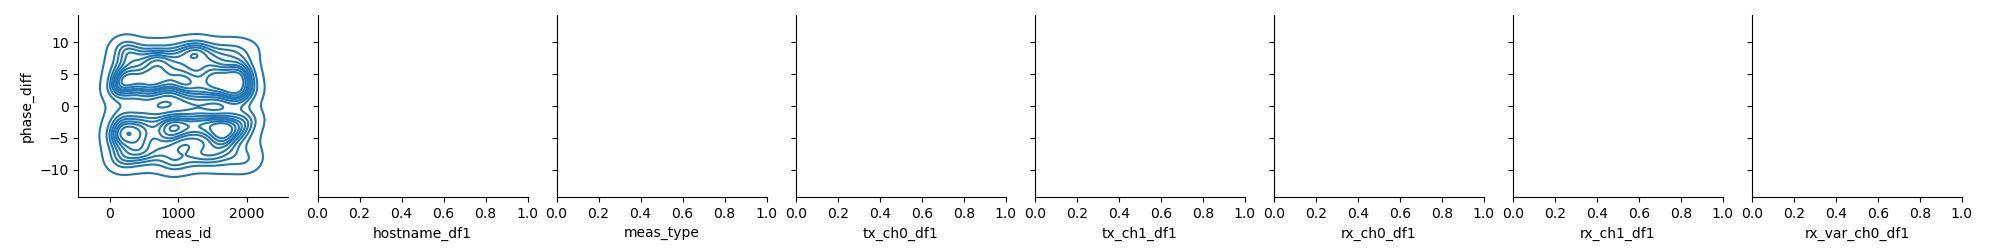

In [12]:
_df = merged_df[np.abs(merged_df["phase_diff"]) < 10]
cols = _df.columns.values
sns.pairplot(_df, y_vars=["phase_diff"], x_vars=cols[:8], dropna=True, kind="kde")
sns.pairplot(_df, y_vars=["phase_diff"], x_vars=cols[8:16], dropna=True, kind="kde")
sns.pairplot(_df, y_vars=["phase_diff"], x_vars=cols[16:], dropna=True, kind="kde")